In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
## USE: full log(returns)/returns dataframe
## Risk Adjusted Returns

df = pd.read_pickle("../Data/risk_adj_returns.pkl").iloc[1:]

drop_columns = []
for col in df.columns:
    if df[col].isnull().all() == True:
        drop_columns.append(col)
        
df.drop(columns=drop_columns, inplace=True)

# df['pct_change'] = df.close.pct_change()
# df['log_ret'] = np.log(df.close) - np.log(df.close.shift(1))
# df = df.dropna()

FileNotFoundError: [Errno 2] No such file or directory: '../Data/risk_adj_returns.pkl'

In [ ]:
#df = df.dropna(how='any',axis=0) #All rows have NaN

In [ ]:
df.tail()

In [ ]:
def get_investable(t, n_rows):
    "Find stocks in investable universe at time t\
    (stocks in the S&P500 that have prices recorded for the last n_rows days)"
    
    df_investable = df.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index + 1:t_index + n_rows + 1]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n_rows].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [ ]:
df = get_investable(pd.to_datetime('2018-05-11'), 200)
df

In [115]:
tts = train_test_split(df, test_size=0.2, shuffle=False)
train = tts[0]
test = tts[1]

In [89]:
train.tail()

916328    936365    905271    905113    905802    905425  \
date                                                                     
2018-01-24  0.086843 -0.060878 -0.046227 -0.035378 -0.040604 -0.107052   
2018-01-23 -0.101296  0.004714 -0.050551 -0.061059 -0.046081 -0.046885   
2018-01-22 -0.061533 -0.024552 -0.054732 -0.032841 -0.009791 -0.064273   
2018-01-19 -0.062797 -0.016724 -0.052486 -0.061087 -0.114825 -0.091019   
2018-01-18 -0.073463  0.006139 -0.107247 -0.065964 -0.062529 -0.117557   

              906156    916305    992816    921093  ...    311917    69568X  \
date                                                ...                       
2018-01-24 -0.018406  0.023516 -0.081765 -0.048425  ...  0.039346 -0.069803   
2018-01-23 -0.066144  0.003933 -0.045001 -0.077185  ... -0.031648 -0.029116   
2018-01-22 -0.048052 -0.057855 -0.064134  0.078599  ... -0.067072 -0.027526   
2018-01-19 -0.108066 -0.039338 -0.055672 -0.027002  ... -0.034127 -0.007381   
2018-01-18 -0.081579 -0.036407 -0.043482 -0.101182  ... -0.083494 -0.048454   

              543755    77463M    29235J    131745    69487D    68157P  \
date                                                                     
2018-01-24 -0.049203 -0.046054 -0.065294 -0.037852 -0.053071 -0.057027   
2018-01-23 -0.012979  0.030010 -0.026629 -0.066076 -0.050037 -0.054079   
2018-01-22 -0.042841 -0.011384 -0.040361 -0.031047 -0.033746 -0.047707   
2018-01-19 -0.016237 -0.017345 -0.038328 -0.000300 -0.037129  0.011143   
2018-01-18 -0.031065 -0.112387 -0.059193 -0.065166 -0.033061 -0.057664   

              9110RA    292703  
date                            
2018-01-24 -0.058082 -0.098818  
2018-01-23 -0.012997 -0.026405  
2018-01-22 -0.000439 -0.116270  
2018-01-19  0.036480 -0.025287  
2018-01-18 -0.052179 -0.061829  

[5 rows x 651 columns]

In [90]:
test.tail()

916328    936365    905271    905113    905802    905425  \
date                                                                     
2017-12-22 -0.078807 -0.084029 -0.066136 -0.047499 -0.014851 -0.093806   
2017-12-21 -0.085026 -0.045442 -0.064580  0.014185  0.089568 -0.133506   
2017-12-20 -0.063545 -0.027817 -0.065008 -0.001230 -0.014661 -0.089004   
2017-12-19 -0.050861 -0.036636 -0.063441 -0.048355 -0.068352 -0.146375   
2017-12-18 -0.014909  0.075835 -0.033337 -0.019492 -0.041249 -0.148475   

              906156    916305    992816    921093  ...    311917    69568X  \
date                                                ...                       
2017-12-22 -0.049523 -0.065613 -0.045515 -0.058053  ... -0.069039 -0.069658   
2017-12-21 -0.056680 -0.037322 -0.036900 -0.048026  ... -0.072542 -0.020915   
2017-12-20 -0.074594 -0.032630 -0.047993 -0.087811  ... -0.063648 -0.046587   
2017-12-19 -0.071386 -0.033276 -0.069767 -0.073746  ... -0.055227 -0.075748   
2017-12-18 -0.023194 -0.033592 -0.013466 -0.094124  ... -0.033586 -0.058820   

              543755    77463M    29235J    131745    69487D    68157P  \
date                                                                     
2017-12-22 -0.037094 -0.032531 -0.054486 -0.086048 -0.045697 -0.039031   
2017-12-21 -0.060163 -0.009458 -0.068158 -0.010737 -0.046480 -0.026167   
2017-12-20 -0.052069  0.000284 -0.025493  0.057820 -0.040007 -0.038349   
2017-12-19 -0.034308 -0.064443 -0.058609 -0.013522 -0.052349 -0.074513   
2017-12-18 -0.016263 -0.123514  0.001390 -0.078713 -0.037056 -0.002008   

              9110RA    292703  
date                            
2017-12-22 -0.036931 -0.066122  
2017-12-21 -0.017515 -0.077143  
2017-12-20 -0.051338 -0.067136  
2017-12-19 -0.041667 -0.023936  
2017-12-18  0.040300 -0.048953  

[5 rows x 651 columns]

In [91]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)
test_set_scaled = sc.fit_transform(test)
pd.DataFrame(training_set_scaled).head()

0         1         2         3         4         5         6    \
0  0.661406  0.268924  0.592576  0.898381  0.463903  0.520905  0.428907   
1  0.749938  0.412923  0.592817  0.907950  0.652900  0.707915  0.492168   
2  0.663560  0.481413  0.649046  0.932297  0.718004  0.183266  0.483571   
3  0.418774  0.348696  0.540830  0.937832  0.755931  0.027789  0.514947   
4  0.642690  0.472731  0.592738  0.963754  0.602166  0.300429  0.443615   

        7         8         9    ...       641       642       643       644  \
0  0.635693  0.393566  0.393625  ...  0.343729  0.461508  0.571224  0.267475   
1  0.598313  0.634965  0.433506  ...  0.270439  0.505696  0.629955  0.736162   
2  0.556848  0.555032  0.284877  ...  0.512915  0.644981  0.257864  0.492219   
3  0.570130  0.530440  0.453406  ...  0.285238  0.526607  0.378104  0.271760   
4  0.710329  0.557165  0.311118  ...  0.299173  0.729053  0.713267  0.578629   

        645       646       647       648       649       650  
0  0.341550  0.413940  0.525361  0.767988  0.145999  0.538990  
1  0.652450  0.429399  0.575786  0.686922  0.374450  0.391136  
2  0.624836  0.370430  0.532337  0.847700  0.250746  0.469572  
3  0.501054  0.520791  0.558434  0.748023  0.283049  0.408207  
4  0.480257  0.412264  0.443215  0.867883  0.224044  0.394355  

[5 rows x 651 columns]

## Simple multi-layer percepetron (MLP) autoencoder

In [92]:
# calculated log returns (i.e. the log of the difference between the price x+1 and price x)
# windows of train.shape[1] consecutive returns will be produced. 
# Can be normalized with a MinMaxScaler to the range [0,1]??

window_length = training_set_scaled.shape[1]
encoding_dim = 3
epochs = 250

# compress the input to a 3-dimensional latent space. 

# input placeholder
input_window = Input(shape=(window_length,))
# encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_window) #tanh, linear, leakyrelu
# lossy reconstruction of the input
decoded = Dense(window_length, activation='linear')(encoded) #linear

# model mapping an input to its reconstruction
autoencoder = Model(input_window, decoded)

# model mapping an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='MeanSquaredError') #MSE
history = autoencoder.fit(training_set_scaled, training_set_scaled,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(test_set_scaled, test_set_scaled))

decoded_stocks = autoencoder.predict(test_set_scaled)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 651)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1956      
_________________________________________________________________
dense_5 (Dense)              (None, 651)               2604      
Total params: 4,560
Trainable params: 4,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 0.3244 - val_loss: 0.3063
Epoch 2/250
1/1 [==============================] - 0s 40ms/step - loss: 0.3210 - val_loss: 0.3045
Epoch 3/250
1/1 [==============================] - 0s 38ms/step - loss: 0.3183 - val_loss: 0.3028
Epoch 4/250
1/1 [==============================] - 0s 64ms/step - loss: 0.3161 - val_loss: 0.30

1/1 [==============================] - 0s 70ms/step - loss: 0.0428 - val_loss: 0.0828
Epoch 159/250
1/1 [==============================] - 0s 38ms/step - loss: 0.0425 - val_loss: 0.0827
Epoch 160/250
1/1 [==============================] - 0s 47ms/step - loss: 0.0421 - val_loss: 0.0826
Epoch 161/250
1/1 [==============================] - 0s 44ms/step - loss: 0.0417 - val_loss: 0.0825
Epoch 162/250
1/1 [==============================] - 0s 37ms/step - loss: 0.0414 - val_loss: 0.0823
Epoch 163/250
1/1 [==============================] - 0s 41ms/step - loss: 0.0410 - val_loss: 0.0822
Epoch 164/250
1/1 [==============================] - 0s 37ms/step - loss: 0.0407 - val_loss: 0.0821
Epoch 165/250
1/1 [==============================] - 0s 42ms/step - loss: 0.0404 - val_loss: 0.0821
Epoch 166/250
1/1 [==============================] - 0s 59ms/step - loss: 0.0400 - val_loss: 0.0820
Epoch 167/250
1/1 [==============================] - 0s 28ms/step - loss: 0.0397 - val_loss: 0.0819
Epoch 168/250


1/1 [==============================] - 0s 42ms/step - loss: 0.0267 - val_loss: 0.0828
Epoch 241/250
1/1 [==============================] - 0s 34ms/step - loss: 0.0266 - val_loss: 0.0828
Epoch 242/250
1/1 [==============================] - 0s 33ms/step - loss: 0.0266 - val_loss: 0.0829
Epoch 243/250
1/1 [==============================] - 0s 29ms/step - loss: 0.0265 - val_loss: 0.0829
Epoch 244/250
1/1 [==============================] - 0s 34ms/step - loss: 0.0264 - val_loss: 0.0830
Epoch 245/250
1/1 [==============================] - 0s 33ms/step - loss: 0.0263 - val_loss: 0.0830
Epoch 246/250
1/1 [==============================] - 0s 33ms/step - loss: 0.0262 - val_loss: 0.0831
Epoch 247/250
1/1 [==============================] - 0s 31ms/step - loss: 0.0261 - val_loss: 0.0831
Epoch 248/250
1/1 [==============================] - 0s 35ms/step - loss: 0.0261 - val_loss: 0.0832
Epoch 249/250
1/1 [==============================] - 0s 47ms/step - loss: 0.0260 - val_loss: 0.0832
Epoch 250/250


In [93]:
pd.DataFrame(encoder.predict(test_set_scaled))

0         1         2
0   0.999518  0.994275  0.999643
1   0.908336  0.292791  0.841821
2   0.998569  0.997075  0.998604
3   0.999847  0.994274  0.998673
4   0.963921  0.936493  0.978588
5   0.996810  0.995636  0.983830
6   0.998032  0.985865  0.998081
7   0.999212  0.990228  0.997315
8   0.998383  0.989224  0.995926
9   0.995750  0.999014  0.998131
10  0.998659  0.995006  0.999174
11  0.924246  0.605332  0.967869
12  0.995831  0.982555  0.996322
13  0.981833  0.973615  0.994862
14  0.988681  0.897790  0.985851
15  0.987088  0.854057  0.989420
16  0.994213  0.954220  0.996957
17  0.996720  0.891146  0.990824
18  0.965192  0.954485  0.990664
19  0.999150  0.998328  0.999636

In [94]:
pd.DataFrame(decoded_stocks)

0         1         2         3         4         5         6    \
0   0.483645  0.361467  0.554238  0.710514  0.568284  0.480299  0.423669   
1   0.395633  0.276065  0.413185  0.520224  0.456285  0.312599  0.358712   
2   0.483616  0.361465  0.554362  0.710801  0.568189  0.480785  0.423600   
3   0.483518  0.361396  0.554118  0.710424  0.568176  0.480281  0.423687   
4   0.472673  0.350223  0.537816  0.688879  0.552320  0.463823  0.412580   
5   0.480985  0.359481  0.551479  0.707980  0.565124  0.479652  0.422500   
6   0.482609  0.360434  0.552554  0.708216  0.566925  0.478271  0.422831   
7   0.482930  0.360841  0.553217  0.709241  0.567430  0.479284  0.423271   
8   0.482557  0.360505  0.552735  0.708676  0.566934  0.478934  0.422991   
9   0.483447  0.361238  0.554222  0.710671  0.567757  0.480956  0.423151   
10  0.483553  0.361372  0.554163  0.710456  0.568108  0.480367  0.423525   
11  0.441631  0.317474  0.482237  0.609172  0.511285  0.387845  0.385501   
12  0.481878  0.359708  0.551501  0.706866  0.565882  0.477289  0.422139   
13  0.479733  0.357172  0.548211  0.702351  0.562118  0.474129  0.418883   
14  0.472955  0.350811  0.536363  0.685815  0.554592  0.457734  0.415426   
15  0.469970  0.347475  0.530301  0.676653  0.550739  0.448226  0.412776   
16  0.479624  0.357290  0.547223  0.700579  0.562980  0.471004  0.420233   
17  0.473928  0.351776  0.537199  0.686489  0.556354  0.457168  0.416810   
18  0.476124  0.353191  0.542635  0.694782  0.556399  0.468404  0.414412   
19  0.483929  0.361752  0.554790  0.711324  0.568600  0.481153  0.423831   

         7         8         9    ...       641       642       643       644  \
0   0.573898  0.517194  0.409517  ...  0.294879  0.550146  0.515443  0.398634   
1   0.417652  0.348625  0.263294  ...  0.267948  0.460260  0.363751  0.325871   
2   0.574170  0.517495  0.409927  ...  0.294631  0.549918  0.515754  0.398578   
3   0.573871  0.517027  0.409515  ...  0.294782  0.550025  0.515427  0.398576   
4   0.555803  0.500534  0.394656  ...  0.288762  0.535541  0.498433  0.388106   
5   0.572389  0.514375  0.409019  ...  0.292483  0.546619  0.514282  0.396723   
6   0.571989  0.515217  0.407739  ...  0.294561  0.549054  0.513590  0.397744   
7   0.572914  0.515966  0.408648  ...  0.294556  0.549398  0.514507  0.398096   
8   0.572480  0.515476  0.408337  ...  0.294291  0.548903  0.514115  0.397779   
9   0.574028  0.517653  0.410023  ...  0.294275  0.549374  0.515677  0.398280   
10  0.573854  0.517208  0.409562  ...  0.294726  0.549926  0.515424  0.398518   
11  0.487909  0.433042  0.327988  ...  0.284926  0.506139  0.431435  0.360816   
12  0.570880  0.514152  0.406855  ...  0.294120  0.548078  0.512557  0.397062   
13  0.566854  0.511527  0.403841  ...  0.292562  0.544461  0.508834  0.394501   
14  0.553344  0.495567  0.389815  ...  0.292406  0.539659  0.495334  0.389671   
15  0.545385  0.487751  0.381503  ...  0.292932  0.537474  0.487328  0.387064   
16  0.565488  0.508748  0.401362  ...  0.294178  0.546219  0.507177  0.395122   
17  0.553847  0.495582  0.389449  ...  0.293910  0.541848  0.495582  0.390825   
18  0.560307  0.506311  0.398568  ...  0.290420  0.539187  0.502692  0.390664   
19  0.574579  0.517956  0.410251  ...  0.294822  0.550308  0.516133  0.398841   

         645       646       647       648       649       650  
0   0.503561  0.404975  0.508967  0.653606  0.294895  0.473652  
1   0.368478  0.275772  0.429126  0.467670  0.227519  0.315546  
2   0.503796  0.405294  0.508851  0.653842  0.294897  0.474024  
3   0.503580  0.405018  0.508951  0.653425  0.294882  0.473588  
4   0.487059  0.390251  0.495574  0.633590  0.285212  0.457666  
5   0.502650  0.404733  0.507044  0.650095  0.293729  0.472227  
6   0.501884  0.403372  0.507954  0.651410  0.294054  0.471757  
7   0.502763  0.404255  0.508427  0.652242  0.294454  0.472625  
8   0.502397  0.403964  0.508056  0.651646  0.294200  0.472235  
9   0.503581  0.405205  0.508323  0.653836  0.294629  0.4741

In [95]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

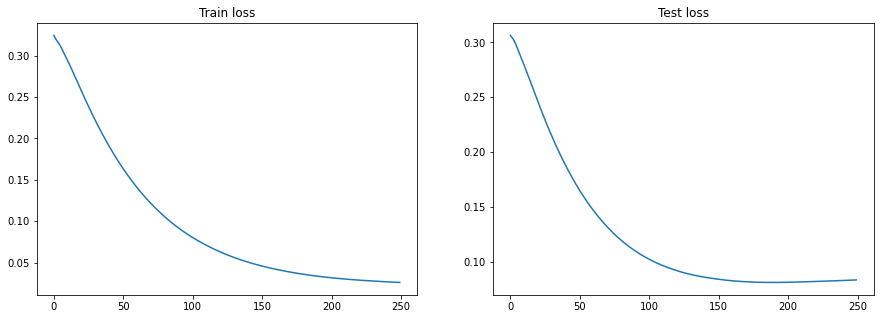

In [96]:
# Loss vs Epoch
plot_history(history)

## 1D convolutional autoencoder
(Kernel size = 3)

In [101]:
# main “event” very well represented while the overall reconstruction is very smooth 

input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="tanh", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="tanh", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="tanh", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='tanh')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='linear', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='MeanSquaredError')
history = autoencoder.fit(train, train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(test, test))

decoded_stocks = autoencoder.predict(test)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 651, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 651, 16)           64        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 326, 16)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 326, 1)            49        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 163, 1)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 163, 1)            4         
_________________________________________________________________
up_sampling1d_8 (UpSampling1 (None, 326, 1)            0  

ValueError: in user code:

    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:830 train_function  *
        return step_function(self, iterator)
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:813 run_step  *
        outputs = model.train_step(data)
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:771 train_step  *
        loss = self.compiled_loss(
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py:201 __call__  *
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:142 __call__  *
        losses = call_fn(y_true, y_pred)
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:246 call  *
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:1202 mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10422 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3557 _create_op_internal
        ret = Operation(
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /Users/anjalichauhan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 650 and 651 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](mean_squared_error/remove_squeezable_dimensions/Squeeze, IteratorGetNext:1)' with input shapes: [?,650], [?,651].


In [ ]:
pd.DataFrame(encoder.predict(test_set_scaled))